In [1]:
import networkx as nx
import wandb

import color_utils
from data_generation.motifs import SparseGraph, CircleMotif, FullyConnectedMotif
from color_utils import ColorUtils
from typing import Optional
from matplotlib import pyplot as plt
import torch
import torch_geometric
from torch_geometric.data import Data
import numpy as np
from analyzer import Analyzer
self = Analyzer("zult4ep0", resume_last=True, device="cpu", batch_size=3000) # If resume_last False, use BEST checkpoint instead"

Didn't find resource module and therefore can't apply fix for wandb logging potentially dying. This is expected on non-unix machines.
Default number of threads: 14, using 14!


0it [00:00, ?it/s]
C:\Users\jonas\OneDrive\Dokumente\Studium\Master\Project\MPhilThesis\analyzer.py:61: UserWarning: Overwriting the batch size can have a significant impact on the clustering and therefore the inference behaviour!
  warnings.warn("Overwriting the batch size can have a significant impact on the clustering and therefore "


Remapping assignments between batches!


100%|██████████| 1/1 [00:00<00:00, 20.82it/s]

Loaded 10 test samples. Accuracy 80.00%


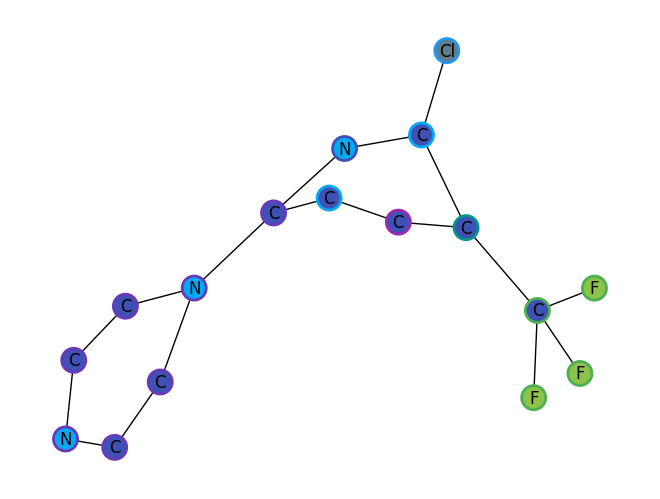

In [4]:
node_table, edge_table = self.log_graphs(10)
self.plot_wandb_tables(node_table, edge_table, 0, 2)

In [3]:


###### MUTAG
NO2 = SparseGraph(torch.tensor([3, 1, 1], dtype=torch.long),
                  torch.tensor([[0, 1, 0, 2],
                                [1, 0, 2, 0]], dtype=torch.long))
FO2 = SparseGraph(torch.tensor([5, 1, 1], dtype=torch.long),
                  torch.tensor([[0, 1, 0, 2],
                                [1, 0, 2, 0]], dtype=torch.long))
SO2 = SparseGraph(torch.tensor([7, 1, 1], dtype=torch.long),
                  torch.tensor([[0, 1, 0, 2],
                                [1, 0, 2, 0]], dtype=torch.long))
carbon_ring = CircleMotif(6, [0], 1).sample()
# TODO also 2/3 merged rings. Add option to search for multiple motifs together. Actually, this could give a really nice, final joint chart with all the important motifs and how they are distributed


In [ ]:
### BBBP
atom_names = ['H', 'B', 'C', 'N', 'O', 'F', 'Na', 'P', 'S', 'Cl', 'Ca', 'Br', 'I']

NO2 = SparseGraph(torch.tensor([3, 4, 4], dtype=torch.long),
                  torch.tensor([[0, 1, 0, 2],
                                [1, 0, 2, 0]], dtype=torch.long))
FO2 = SparseGraph(torch.tensor([5, 4, 4], dtype=torch.long),
                  torch.tensor([[0, 1, 0, 2],
                                [1, 0, 2, 0]], dtype=torch.long))
SO2 = SparseGraph(torch.tensor([8, 4, 4], dtype=torch.long),
                  torch.tensor([[0, 1, 0, 2],
                                [1, 0, 2, 0]], dtype=torch.long))
carbon_ring = CircleMotif(6, [2], 3).sample()
carbon_ring.x = torch.argmax(carbon_ring.x, dim=-1)

In [ ]:
FC4 = FullyConnectedMotif(4, [0], 1).sample()
FC4.x = torch.argmax(FC4.x, dim=-1)

In [ ]:




#
# find_subgraph(self, FC4.edge_index, FC4.x.squeeze(-1), pool_step=0, load_part=1)

In [ ]:
torch.as_tensor(torch.tensor(4))

In [ ]:
def one_hot(indices: int | torch.Tensor, num_classes: Optional[int] = None, **kwargs):
    indices = torch.as_tensor(indices)
    assert indices.ndim <= 1 # Otherwise would need to deal with arange over arbitrary number of dimensions
    if num_classes is None:
        num_classes = torch.max(indices) + 1
    res = torch.zeros(indices.shape + (num_classes, ), **kwargs)
    if indices.ndim == 0:
        res[indices] = 1
    else:
        res[torch.arange(indices.shape[0]), indices] = 1
    return res

one_hot(2, 10)

In [ ]:
def plot_subgraph(edge_index, concepts):
    to_networkx()

In [ ]:
from tqdm import tqdm
from graphutils import adj_to_edge_index
from torch_geometric.utils import to_networkx, k_hop_subgraph
import networkx.algorithms.isomorphism as iso
from graphutils import one_hot

def count_subgraphs(self, pool_step: int, load_part: float = 1, save_path: Optional[str] = None):
    required_fields = ["info_pooling_assignments"]
    if pool_step != 0:
        required_fields += ["info_all_batch_or_mask", "info_adjs_or_edge_indices", "info_node_assignments"]
    else:
        required_fields += ["x", "mask", "adj"] # TODO use test if not significantly worse
    test_data = self.load_required_data(self.train_loader, load_part, "train", required_fields)

    if pool_step == 0:
        self.check_one_hot(test_data["x"][test_data["mask"]])
        initial_concepts = torch.argmax(test_data["x"], dim=-1).cpu()
        adj = test_data["adj"].cpu()
        mask = test_data["mask"].cpu()
    else:
        initial_concepts = test_data["info_node_assignments"][pool_step - 1].cpu()
        adj = test_data["info_adjs_or_edge_indices"][pool_step - 1].cpu()
        mask = test_data["info_all_batch_or_mask"][pool_step - 1].cpu()
    assignment = test_data["info_pooling_assignments"][pool_step].cpu()

    checked = torch.logical_not(mask)  # masked nodes count as checked
    # Would easily be parallelizable over samples
    concept_counts = torch.zeros(torch.max(assignment) + 1, dtype=torch.int)
    buckets = {}
    for sample in tqdm(range(checked.shape[0])):
        nodes_in_cur_graph = torch.sum(mask[sample]).item()
        edge_index, _, _ = adj_to_edge_index(adj[sample], mask[sample])
        # plot_nx_graph(to_networkx(Data(#concept=initial_concepts[sample][mask[sample]],
        #     concept=assignment[sample][mask[sample]], edge_index=edge_index, num_nodes=nodes_in_cur_graph), to_undirected=not self.dataset_wrapper.is_directed, node_attrs=["concept"]))
        # plt.show()
        edge_index = edge_index[:, assignment[sample, edge_index[0, :]] == assignment[sample, edge_index[1, :]]]

        # plot_nx_graph(to_networkx(Data(concept=assignment[sample][mask[sample]], edge_index=edge_index, num_nodes=nodes_in_cur_graph), to_undirected=not self.dataset_wrapper.is_directed, node_attrs=["concept"]))
        # plt.show()
        # break

        for node in range(checked.shape[1]):
            if checked[sample, node]:
                continue
            subset, edge_index_loc, mapping, _ = k_hop_subgraph(node, nodes_in_cur_graph,
                                                            edge_index,
                                                            relabel_nodes=True,
                                                            num_nodes=nodes_in_cur_graph)
            checked[sample, mapping] = True
            cur_concept = assignment[sample, node]
            concept_counts[cur_concept] += 1

            cur_graph = to_networkx(Data(concept=initial_concepts[sample][subset], edge_index=edge_index_loc,
                                         num_nodes=subset.shape[0]),
                                    to_undirected=not self.dataset_wrapper.is_directed,
                                    node_attrs=["concept"])
            key = nx.algorithms.graph_hashing.weisfeiler_lehman_graph_hash(cur_graph, node_attr="concept")

            if key in buckets:
                for other_graph, occurrences in buckets[key].items():
                    if nx.is_isomorphic(other_graph, cur_graph, node_match=iso.categorical_node_match("concept", None)):
                        buckets[key][other_graph][cur_concept] += 1
                        break
                else:
                    buckets[key][cur_graph] = one_hot(cur_concept, concept_counts.shape[0], dtype=torch.int)
            else:
                buckets[key] = {cur_graph: one_hot(cur_concept, concept_counts.shape[0], dtype=torch.int)}

    subgraphs = []
    for key in buckets:
        for g, counts in buckets[key].items():
            subgraphs.append((g, counts))
    subgraphs.sort(key=lambda x: torch.sum(x[1]), reverse=True)

    fig, ax = plt.subplots()
    bottom = torch.zeros_like(concept_counts)
    for i, (g, counts) in enumerate(subgraphs):
        ax.bar(np.arange(concept_counts.shape[0]), counts, bottom=bottom, label=f"{i}")
        bottom += counts
    if save_path:
        fig.savefig(f"{save_path}.pdf", bbox_inches='tight')
    return subgraphs


subgraphs = count_subgraphs(self, pool_step=0, load_part=1)

In [ ]:
graph = list(buckets['bcb666336cd11cfe336b4f388b7d82e1'].keys())[0]
concepts_dict = nx.get_node_attributes(graph, "concept")
concepts = torch.tensor(len(c))

In [ ]:
from typing import List, Tuple


def tuples_to_tensor(inputs: dict, **kwargs):
    res = torch.empty(len(inputs), **kwargs)
    for i, j in inputs.items():
        res[i] = j
    return res

def plot_nx_concept_graph(self, graph):
    concepts_dict = nx.get_node_attributes(graph, "concept")
    concepts = tuples_to_tensor(concepts_dict, dtype=torch.long)
    ColorUtils.ensure_min_hex_colors(torch.max(concepts) + 1)
    kwargs = {}
    use_labels = ColorUtils.feature_labels is not None

    nx.draw(graph, node_color=ColorUtils.hex_colors[concepts.numpy()],
            node_size=300 if use_labels else 100,
            labels= {i: ColorUtils.feature_labels[concepts[i]] for  i in range(concepts.shape[0])} if use_labels else None
            )

for graph, occs in subgraphs[:20]:
    plot_nx_concept_graph(self, graph)
    plt.show()

In [7]:
self.calculate_concept_completeness(seeds=list(range(10)))

Remapping assignments between batches!


100%|██████████| 1/1 [00:01<00:00,  1.65s/it]
C:\Users\jonas\anaconda3\envs\HierarchicalClusters\lib\site-packages\functorch\_src\vmap.py:489: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::bincount. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at ..\aten\src\ATen\functorch\BatchedFallback.cpp:84.)
  batched_outputs = func(*batched_inputs, **kwargs)
C:\Users\jonas\anaconda3\envs\HierarchicalClusters\lib\site-packages\functorch\_src\vmap.py:489: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::bincount. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at ..\aten\src\ATen\functorch\BatchedFallback.cpp:84.)
  batched_outputs = func(*batched_inputs, **kwargs)
C:\Users\jonas\anaconda3\envs\HierarchicalClusters\lib\site-packages\functorch\_src\vmap.py:489: UserWarning: Th

Loaded 1836 joint train and test samples. Accuracy 88.13%
Remapping assignments between batches!


100%|██████████| 1/1 [00:01<00:00,  1.76s/it]
C:\Users\jonas\anaconda3\envs\HierarchicalClusters\lib\site-packages\functorch\_src\vmap.py:489: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::bincount. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at ..\aten\src\ATen\functorch\BatchedFallback.cpp:84.)
  batched_outputs = func(*batched_inputs, **kwargs)
C:\Users\jonas\anaconda3\envs\HierarchicalClusters\lib\site-packages\functorch\_src\vmap.py:489: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::bincount. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at ..\aten\src\ATen\functorch\BatchedFallback.cpp:84.)
  batched_outputs = func(*batched_inputs, **kwargs)
C:\Users\jonas\anaconda3\envs\HierarchicalClusters\lib\site-packages\functorch\_src\vmap.py:489: UserWarning: Th

Loaded 1836 joint train and test samples. Accuracy 88.13%
Remapping assignments between batches!


100%|██████████| 1/1 [00:01<00:00,  1.59s/it]
C:\Users\jonas\anaconda3\envs\HierarchicalClusters\lib\site-packages\functorch\_src\vmap.py:489: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::bincount. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at ..\aten\src\ATen\functorch\BatchedFallback.cpp:84.)
  batched_outputs = func(*batched_inputs, **kwargs)
C:\Users\jonas\anaconda3\envs\HierarchicalClusters\lib\site-packages\functorch\_src\vmap.py:489: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::bincount. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at ..\aten\src\ATen\functorch\BatchedFallback.cpp:84.)
  batched_outputs = func(*batched_inputs, **kwargs)
C:\Users\jonas\anaconda3\envs\HierarchicalClusters\lib\site-packages\functorch\_src\vmap.py:489: UserWarning: Th

Loaded 1836 joint train and test samples. Accuracy 87.58%
Remapping assignments between batches!


100%|██████████| 1/1 [00:01<00:00,  1.77s/it]
C:\Users\jonas\anaconda3\envs\HierarchicalClusters\lib\site-packages\functorch\_src\vmap.py:489: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::bincount. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at ..\aten\src\ATen\functorch\BatchedFallback.cpp:84.)
  batched_outputs = func(*batched_inputs, **kwargs)
C:\Users\jonas\anaconda3\envs\HierarchicalClusters\lib\site-packages\functorch\_src\vmap.py:489: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::bincount. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at ..\aten\src\ATen\functorch\BatchedFallback.cpp:84.)
  batched_outputs = func(*batched_inputs, **kwargs)
C:\Users\jonas\anaconda3\envs\HierarchicalClusters\lib\site-packages\functorch\_src\vmap.py:489: UserWarning: Th

Loaded 1836 joint train and test samples. Accuracy 86.93%
Remapping assignments between batches!


100%|██████████| 1/1 [00:01<00:00,  1.85s/it]
C:\Users\jonas\anaconda3\envs\HierarchicalClusters\lib\site-packages\functorch\_src\vmap.py:489: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::bincount. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at ..\aten\src\ATen\functorch\BatchedFallback.cpp:84.)
  batched_outputs = func(*batched_inputs, **kwargs)
C:\Users\jonas\anaconda3\envs\HierarchicalClusters\lib\site-packages\functorch\_src\vmap.py:489: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::bincount. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at ..\aten\src\ATen\functorch\BatchedFallback.cpp:84.)
  batched_outputs = func(*batched_inputs, **kwargs)
C:\Users\jonas\anaconda3\envs\HierarchicalClusters\lib\site-packages\functorch\_src\vmap.py:489: UserWarning: Th

Loaded 1836 joint train and test samples. Accuracy 87.36%
Remapping assignments between batches!


100%|██████████| 1/1 [00:01<00:00,  1.66s/it]
C:\Users\jonas\anaconda3\envs\HierarchicalClusters\lib\site-packages\functorch\_src\vmap.py:489: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::bincount. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at ..\aten\src\ATen\functorch\BatchedFallback.cpp:84.)
  batched_outputs = func(*batched_inputs, **kwargs)
C:\Users\jonas\anaconda3\envs\HierarchicalClusters\lib\site-packages\functorch\_src\vmap.py:489: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::bincount. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at ..\aten\src\ATen\functorch\BatchedFallback.cpp:84.)
  batched_outputs = func(*batched_inputs, **kwargs)
C:\Users\jonas\anaconda3\envs\HierarchicalClusters\lib\site-packages\functorch\_src\vmap.py:489: UserWarning: Th

Loaded 1836 joint train and test samples. Accuracy 88.45%
Remapping assignments between batches!


100%|██████████| 1/1 [00:01<00:00,  1.83s/it]
C:\Users\jonas\anaconda3\envs\HierarchicalClusters\lib\site-packages\functorch\_src\vmap.py:489: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::bincount. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at ..\aten\src\ATen\functorch\BatchedFallback.cpp:84.)
  batched_outputs = func(*batched_inputs, **kwargs)
C:\Users\jonas\anaconda3\envs\HierarchicalClusters\lib\site-packages\functorch\_src\vmap.py:489: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::bincount. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at ..\aten\src\ATen\functorch\BatchedFallback.cpp:84.)
  batched_outputs = func(*batched_inputs, **kwargs)
C:\Users\jonas\anaconda3\envs\HierarchicalClusters\lib\site-packages\functorch\_src\vmap.py:489: UserWarning: Th

Loaded 1836 joint train and test samples. Accuracy 87.91%
Remapping assignments between batches!


100%|██████████| 1/1 [00:01<00:00,  1.63s/it]
C:\Users\jonas\anaconda3\envs\HierarchicalClusters\lib\site-packages\functorch\_src\vmap.py:489: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::bincount. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at ..\aten\src\ATen\functorch\BatchedFallback.cpp:84.)
  batched_outputs = func(*batched_inputs, **kwargs)
C:\Users\jonas\anaconda3\envs\HierarchicalClusters\lib\site-packages\functorch\_src\vmap.py:489: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::bincount. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at ..\aten\src\ATen\functorch\BatchedFallback.cpp:84.)
  batched_outputs = func(*batched_inputs, **kwargs)
C:\Users\jonas\anaconda3\envs\HierarchicalClusters\lib\site-packages\functorch\_src\vmap.py:489: UserWarning: Th

Loaded 1836 joint train and test samples. Accuracy 87.15%
Remapping assignments between batches!


100%|██████████| 1/1 [00:01<00:00,  1.64s/it]
C:\Users\jonas\anaconda3\envs\HierarchicalClusters\lib\site-packages\functorch\_src\vmap.py:489: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::bincount. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at ..\aten\src\ATen\functorch\BatchedFallback.cpp:84.)
  batched_outputs = func(*batched_inputs, **kwargs)
C:\Users\jonas\anaconda3\envs\HierarchicalClusters\lib\site-packages\functorch\_src\vmap.py:489: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::bincount. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at ..\aten\src\ATen\functorch\BatchedFallback.cpp:84.)
  batched_outputs = func(*batched_inputs, **kwargs)
C:\Users\jonas\anaconda3\envs\HierarchicalClusters\lib\site-packages\functorch\_src\vmap.py:489: UserWarning: Th

Loaded 1836 joint train and test samples. Accuracy 87.31%
Remapping assignments between batches!


100%|██████████| 1/1 [00:01<00:00,  1.52s/it]

Loaded 1836 joint train and test samples. Accuracy 88.07%
79.37%+-1.03
82.83%+-2.47
82.78%+-2.21



C:\Users\jonas\anaconda3\envs\HierarchicalClusters\lib\site-packages\functorch\_src\vmap.py:489: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::bincount. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at ..\aten\src\ATen\functorch\BatchedFallback.cpp:84.)
  batched_outputs = func(*batched_inputs, **kwargs)
C:\Users\jonas\anaconda3\envs\HierarchicalClusters\lib\site-packages\functorch\_src\vmap.py:489: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::bincount. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at ..\aten\src\ATen\functorch\BatchedFallback.cpp:84.)
  batched_outputs = func(*batched_inputs, **kwargs)
C:\Users\jonas\anaconda3\envs\HierarchicalClusters\lib\site-packages\functorch\_src\vmap.py:489: UserWarning: There is a performance drop because we have not

tensor([[0.8146, 0.8390, 0.8732],
        [0.7805, 0.8341, 0.8341],
        [0.7902, 0.8341, 0.8390],
        [0.7902, 0.8537, 0.8146],
        [0.7902, 0.8049, 0.7951],
        [0.8049, 0.8585, 0.8244],
        [0.7951, 0.8049, 0.8000],
        [0.7951, 0.8537, 0.8293],
        [0.7951, 0.8146, 0.8390],
        [0.7805, 0.7854, 0.8293]], dtype=torch.float64)